# Imports

In [ ]:
import os
import pickle
from collections import OrderedDict
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn as nn
import cv2
import random
import torchvision.transforms as transforms
from torch.utils import data
from torch.nn import functional as F
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import numpy as np
import torch.optim as optim
import torchvision.datasets as td
from torchvision import transforms
from PIL import Image
from skimage.feature import hog as hog
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix,f1_score, accuracy_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder

In [ ]:
from google.colab import drive
import pathlib

drive.mount('/content/drive', force_remount=True)

drive = pathlib.Path('./drive/MyDrive') / 'ML_Project' / 'ML_FP_2022'

Mounted at /content/drive


# Load data

In [ ]:
with open(drive / "data2022" / "multi-task" / "label_v1" / "eval_label.pickle", 'rb') as pickle_file:
  eval_ = pickle.load(pickle_file)
pickle_file.close()

with open(drive / "data2022" / "multi-task" / "label_v1" / "test_label.pickle", 'rb') as pickle_file:
  test_ = pickle.load(pickle_file)
pickle_file.close()

with open(drive / "data2022" / "multi-task" / "label_v1" / "train_label.pickle", 'rb') as pickle_file:
  train_ = pickle.load(pickle_file)
pickle_file.close()

# Define preprocessor and label encoder

In [ ]:
#data augmentation, define image preprocessor
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   
])

labels_c = train_['creator']+test_['creator']+eval_['creator']
encoder_c = LabelEncoder()
encoder_c.fit(labels_c)

labels_m = train_['material']+test_['material']+eval_['material']
encoder_m = MultiLabelBinarizer()
encoder_m.fit(labels_m)

labels_t = train_['type']+test_['type']+eval_['type']
encoder_t = MultiLabelBinarizer()
encoder_t.fit(labels_t)

MultiLabelBinarizer()

In [ ]:
encoder_c.classes_

array(['Callot, Jacques', 'Collaert, Adriaen', 'Fokke, Simon',
       'Galle, Philips', 'Gheyn, Jacob de (II)', 'Goltzius, Hendrick',
       'Hogenberg, Frans', 'Hooghe, Romeyn de', 'Houbraken, Jacob',
       'Luyken, Jan', 'Meissener Porzellan Manufaktur',
       'Passe, Crispijn van de (I)', 'Picart, Bernard',
       'Rembrandt Harmensz. van Rijn', 'Vinkeles, Reinier'], dtype='<U30')

In [ ]:
print(encoder_c.classes_.shape)

(15,)


In [ ]:
encoder_m.classes_

array(['Japans papier', 'dekverf', 'doek', 'ebbenhout', 'eikenhout',
       'fluweel', 'goud', 'hout', 'inkt', 'koper', 'krijt', 'leer',
       'olieverf', 'paneel', 'papier', 'porselein', 'potlood', 'staal',
       'steengoed', 'verf', 'waterverf', 'zilver'], dtype=object)

In [ ]:
print(encoder_m.classes_.shape)

(22,)


In [ ]:
encoder_t.classes_

array(['adreskaart', 'album', 'albumblad', 'almanak', 'beker',
       'bestekfoedraal', 'bierpul', 'boek', 'boekillustratie',
       'bord (vaatwerk)', 'boterspaan', 'brief', 'chocoladekan',
       'chocoladekop', 'dessertbord', 'dienblad', 'eet- en drinkgerei',
       'embleem', 'fragment', 'frontispice', 'handschrift',
       'historieplaat', 'historieprent', 'historisch objectvoorstelling',
       'huwelijksprent', 'kaart', 'kan', 'koffie- en theeservies',
       'koffiekan', 'kom', 'kop', 'kop-en-schotel', 'kostuumprent',
       'lepel', 'lidmaatschapsbewijs', 'loterijprent', 'maculatuur',
       'melkkan', 'modeprent', 'nieuwsprent', 'ontwerp', 'ornamentprent',
       'pamflet', 'pattipan', 'plattegrond', 'portret', 'prent',
       'proefdruk (prent)', 'promotieprent', 'propagandaprent',
       'reisbestek', 'sauskom', 'schaal (objectnaam)', 'schilderij',
       'schotel', 'servies', 'soepbord', 'specerijdoos', 'spoelkom',
       'spotprent', 'suikerbak', 'suikerdoos', 'suikerpot'

In [ ]:
print(encoder_t.classes_.shape)

(76,)


# Dataset

In [ ]:
class train_dataset():
  def __init__(self, dict_ = train_, encoder = [encoder_c, encoder_m, encoder_t]):
    #load data
    self.transform = preprocess
    self.image = dict_['identifier']
    self.creator = encoder[0].transform(dict_['creator'])
    self.material = encoder[1].transform(dict_['material'])
    self.art_type = encoder[2].transform(dict_['type'])
    
  def __len__(self):
    return len(self.image)

  def __getitem__(self, index, img_path=drive / "data2022" / "multi-task" / 'data' / "train set new"):
    # img augmentation
    img = cv2.imread(os.path.join(img_path / self.image[index]))
    img = self.transform(img)
    
    #label
    creator = self.creator[index]
    material = self.material[index]
    art_type = self.art_type[index]

    sample = {'image' : img, 'creator' : creator, 'material' : material, 'type' : art_type}
    return sample

In [ ]:
class test_dataset():
  def __init__(self, dict_ = test_, encoder = [encoder_c, encoder_m, encoder_t]):
    #load data
    self.transform = preprocess
    self.image = dict_['identifier']
    self.creator = encoder[0].transform(dict_['creator'])
    self.material = encoder[1].transform(dict_['material'])
    self.art_type = encoder[2].transform(dict_['type'])
    
  def __len__(self):
    return len(self.image)

  def __getitem__(self, index, img_path=drive / "data2022" / "multi-task" / 'data' / "test set"):
    # img augmentation
    img = cv2.imread(os.path.join(img_path / self.image[index]))
    img = self.transform(img)
    
    #label
    creator = self.creator[index]
    material = self.material[index]
    art_type = self.art_type[index]

    sample = {'image' : img, 'creator' : creator, 'material' : material, 'type' : art_type}
    return sample

In [ ]:
class val_dataset():
  def __init__(self, dict_ = eval_, encoder = [encoder_c, encoder_m, encoder_t]):
    #load data
    self.transform = preprocess
    self.image = dict_['identifier']
    self.creator = encoder[0].transform(dict_['creator'])
    self.material = encoder[1].transform(dict_['material'])
    self.art_type = encoder[2].transform(dict_['type'])
    
  def __len__(self):
    return len(self.image)

  def __getitem__(self, index, img_path=drive / "data2022" / "multi-task" / 'data' / "eval set"):
    # img augmentation
    img = cv2.imread(os.path.join(img_path / self.image[index]))
    img = self.transform(img)
    
    #label
    creator = self.creator[index]
    material = self.material[index]
    art_type = self.art_type[index]

    sample = {'image' : img, 'creator' : creator, 'material' : material, 'type' : art_type}
    return sample

In [ ]:
train = train_dataset()
test = test_dataset()
val = val_dataset()

# Data Loader

In [ ]:
BATCH_SIZE = 16
BATCH_SIZE_VAL = 1

train_dataloader = DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test, shuffle=False, batch_size=BATCH_SIZE_VAL)
val_dataloader = DataLoader(val, shuffle=False, batch_size=BATCH_SIZE_VAL)

# Early Stopping

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Train and Evaluate Module

In [ ]:
###main train and evaluate function ###
from tqdm import tqdm
import time

def train_main(model,loss_,optimizer,train_dataloader,device, epoch):
  # loss_epoch=[]
  # loss_each=[[],[],[]]
  loss_train = 0
  model.train()
  for data in train_dataloader:
      ##(b,c,h,w)
      images = torch.Tensor(data['image']).to(device)
      label_c = torch.Tensor(data['creator']).to(device)
      label_m = torch.Tensor(data['material']).to(device)
      label_t = torch.Tensor(data['type']).to(device)
      #print(images.shape)
      optimizer.zero_grad()
      outputs_c, outputs_m, outputs_t = model(images)
      outputs_m=outputs_m.unsqueeze(1).float()
      outputs_t=outputs_t.unsqueeze(1).float()
      label_m=label_m.unsqueeze(1).float()
      label_t=label_t.unsqueeze(1).float()

      loss_c = loss_[0](outputs_c, label_c)
      loss_m = loss_[1](outputs_m, label_m)
      loss_t = loss_[2](outputs_t, label_t)
      # print(loss_c.detach().cpu().numpy().ravel(), loss_m.detach().cpu().numpy().ravel() , loss_t.detach().cpu().numpy().ravel())
      # loss_each[0].append(loss_c.item())
      # loss_each[1].append(loss_m.item())
      # loss_each[2].append(loss_t.item())
      # total_loss
      loss = loss_c + 0.08*loss_m + loss_t
      loss_train += loss.item()
      #loss = loss_[1](outputs_m, label_m) + loss_[2](outputs_t, label_t)
      loss.backward()
      optimizer.step()
      # loss_epoch.append(loss.item())
  return loss_train

def val_test(model,val_dataloader):
  predict_clist=[]
  predict_mlist=[]
  predict_tlist=[]
  loss_val = 0
  y_c = []
  y_m = []
  y_t = []
  with torch.no_grad():
    model.eval()
    for batchind,data in enumerate(val_dataloader):
      images = torch.Tensor(data['image']).to(device)
      label_c = torch.Tensor(data['creator']).to(device)
      label_m = torch.Tensor(data['material']).to(device)
      label_t = torch.Tensor(data['type']).to(device)
      
      outputs_c, outputs_m, outputs_t = model(images)
      outputs_m1=outputs_m.unsqueeze(1).float()
      outputs_t1=outputs_t.unsqueeze(1).float()
      label_m1=label_m.unsqueeze(1).float()
      label_t1=label_t.unsqueeze(1).float()
      ##change to (1,c,h,w)

      loss_c = loss_[0](outputs_c, label_c)
      loss_m = loss_[1](outputs_m1, label_m1)
      loss_t = loss_[2](outputs_t1, label_t1)
      # total_loss
      loss= loss_c + 0.08*loss_m + loss_t
      loss_val += loss.item()

      softmax = nn.Softmax()
      outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
      outputs_m=outputs_m.float()
      outputs_t=outputs_t.float()
      label_c=label_c
      label_m=label_m.float()
      label_t=label_t.float()

      # predict creator
      predict_clist.append(outputs_c.detach().cpu().numpy().ravel())
      y_c.append(torch.Tensor.round(label_c).detach().cpu().numpy().ravel())
      # predict material
      predict_mlist.append(torch.Tensor.round(outputs_m).detach().cpu().numpy().ravel())
      y_m.append(torch.Tensor.round(label_m).detach().cpu().numpy().ravel())
      # predict type
      predict_tlist.append(torch.Tensor.round(outputs_t).detach().cpu().numpy().ravel())
      y_t.append(torch.Tensor.round(label_t).detach().cpu().numpy().ravel())
  # print(y_m[0].shape)
  # print(predict_mlist[0].shape)
  # print(y_t[0].shape)
  # print(predict_tlist[0].shape) 

  #Artist aacc
  aacc = 0
  for index in range(len(predict_clist)):
    aacc = aacc + accuracy_score(y_c[index], predict_clist[index])
  aacc = aacc / len(predict_clist)

  #material mmAP
  mmAp = 0
  for index in range(len(predict_mlist)):
    mmAp = mmAp + average_precision_score(y_m[index], predict_mlist[index])
  mmAp = mmAp / len(predict_mlist)

  #type tmAP
  tmAp = 0
  for index in range(len(predict_tlist)):
    tmAp = tmAp + average_precision_score(y_t[index], predict_tlist[index])
  tmAp = tmAp / len(predict_tlist)
  
  return loss_val, [predict_clist, predict_mlist, predict_tlist], [y_c, y_m, y_t], [aacc, mmAp, tmAp]

import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,balanced_accuracy_score

def eval_all(predict_list, truth_label):
  #creator
  acc=0
  for index in range(len(predict_list[0])):
    acc = acc + accuracy_score(truth_label[0][index], predict_list[0][index])
  acc = acc / len(predict_list[0])
  f1_c=f1_score(truth_label[0],predict_list[0],average='micro')
  recal_c = recall_score(truth_label[0],predict_list[0],average='micro')
  prec_c = precision_score(truth_label[0],predict_list[0],average='micro')
  mac_c = balanced_accuracy_score(truth_label[0],predict_list[0])
  con_mat_c=confusion_matrix(truth_label[0],predict_list[0])

  #material
  mmAp = 0
  for index in range(len(predict_list[1])):
    mmAp = mmAp + average_precision_score(truth_label[1][index], predict_list[1][index], average='weighted')
  mmAp = mmAp / len(predict_list[1])

  mmRecall = 0
  for index in range(len(predict_list[1])):
    mmRecall = mmRecall + recall_score(truth_label[1][index], predict_list[1][index], average='weighted')
  mmRecall = mmRecall/len(predict_list[1])

  mf1 = 2*(mmAp*mmRecall)/(mmAp+mmRecall)

  #type
  tmAp = 0
  for index in range(len(predict_list[2])):
    tmAp = tmAp + average_precision_score(truth_label[2][index], predict_list[2][index], average='weighted')
  tmAp = tmAp / len(predict_list[2])

  tmRecall = 0
  for index in range(len(predict_list[2])):
    tmRecall = tmRecall + recall_score(truth_label[2][index], predict_list[2][index], average='weighted')
  tmRecall = tmRecall/len(predict_list[2])

  tf1 = 2*(tmAp*tmRecall)/(tmAp+tmRecall)

  return [f1_c,recal_c,prec_c,prec_c,mac_c,con_mat_c,acc], [mmAp,mmRecall,mf1], [tmAp,tmRecall,tf1]

# ResNet 50

In [ ]:
##load pretrained resnet50 network ###
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

class HydraNet(nn.Module):
  def __init__(self, resnet50):
    super().__init__()
    self.net  = resnet50
    self.n_features = self.net.fc.out_features

    # head 1, creator
    self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),
                                              ('relu1', nn.ReLU()),
                                              ('output', nn.Linear(self.n_features, 15))]))
    
    # head 2, material
    self.net.fc2 = nn.Sequential(OrderedDict([('linear1', nn.Linear(self.n_features,self.n_features)),
                                              ('relu1', nn.ReLU()),
                                              ('linear2', nn.Linear(self.n_features, 22)),
                                              ('output', nn.Sigmoid())]))
    # head 3, type
    self.net.fc3 = nn.Sequential(OrderedDict([('linear1', nn.Linear(self.n_features,self.n_features)),
                                          ('relu1', nn.ReLU()),
                                          ('linear2', nn.Linear(self.n_features, 76)),
                                          ('output', nn.Sigmoid())]))
  def forward(self, x):
    output_resnet = self.net(x)
    c_head = self.net.fc1(output_resnet)
    m_head = self.net.fc2(output_resnet)
    t_head = self.net.fc3(output_resnet)
    return c_head, m_head, t_head

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


# Train

In [ ]:
num_epochs=50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=HydraNet(resnet50).to(device)
loss_c = nn.CrossEntropyLoss()
loss_m = nn.BCELoss()
loss_t = nn.BCELoss()
loss_ = [loss_c, loss_m, loss_t]
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=(1e-5))
# optimizer: changed to use SGD

In [ ]:
#Train
early_stopping = EarlyStopping(patience=20, verbose=True)
losses_train = []
losses_val = []
for epoch in tqdm(range(num_epochs)):
  loss_train = train_main(model,loss_,optimizer,train_dataloader, device, epoch)
  mean_loss_train = loss_train/len(train_dataloader)
  losses_train.append(mean_loss_train)
  loss_val, predict_r, label, metric =val_test(model, val_dataloader=val_dataloader)
  mean_loss_val = loss_val/len(val_dataloader)
  losses_val.append(mean_loss_val)
  early_stopping(mean_loss_val, model)
  if early_stopping.early_stop:
    print('++++++++++Early Stopping...++++++++++')
    break
  print("training loss:", mean_loss_train)
  print("validation loss:", mean_loss_val)
  print(f'epoch{epoch+1} has been trained')

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (inf --> 0.461431).  Saving model ...


  2%|▏         | 1/50 [24:33<20:03:01, 1473.10s/it]

training loss: 0.8176722916925024
validation loss: 0.46143067553390715
epoch1 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.461431 --> 0.264123).  Saving model ...


  4%|▍         | 2/50 [28:19<9:52:00, 740.02s/it]  

training loss: 0.5164485456879268
validation loss: 0.26412321492270685
epoch2 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.264123 --> 0.179075).  Saving model ...


  6%|▌         | 3/50 [32:11<6:37:56, 508.01s/it]

training loss: 0.3552016974343154
validation loss: 0.17907497366654734
epoch3 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.179075 --> 0.124201).  Saving model ...


  8%|▊         | 4/50 [36:04<5:05:58, 399.11s/it]

training loss: 0.22541005014369409
validation loss: 0.12420123778714241
epoch4 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.124201 --> 0.114310).  Saving model ...


 10%|█         | 5/50 [39:55<4:14:05, 338.79s/it]

training loss: 0.15628667489742626
validation loss: 0.11431009321275801
epoch5 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.114310 --> 0.101233).  Saving model ...


 12%|█▏        | 6/50 [43:47<3:41:47, 302.45s/it]

training loss: 0.11406570851167072
validation loss: 0.10123291439135892
epoch6 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.101233 --> 0.086123).  Saving model ...


 14%|█▍        | 7/50 [47:37<3:19:43, 278.68s/it]

training loss: 0.07958300395807374
validation loss: 0.08612331475550339
epoch7 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 16%|█▌        | 8/50 [51:24<3:03:35, 262.28s/it]

EarlyStopping counter: 1 out of 20
training loss: 0.05715725194135803
validation loss: 0.09677544136138272
epoch8 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 18%|█▊        | 9/50 [55:13<2:51:58, 251.67s/it]

EarlyStopping counter: 2 out of 20
training loss: 0.04762470399302815
validation loss: 0.0916734593835897
epoch9 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 20%|██        | 10/50 [59:00<2:42:43, 244.09s/it]

EarlyStopping counter: 3 out of 20
training loss: 0.04429171732236481
validation loss: 0.08670848048193537
epoch10 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.086123 --> 0.085533).  Saving model ...


 22%|██▏       | 11/50 [1:02:48<2:35:28, 239.19s/it]

training loss: 0.03591359502002932
validation loss: 0.08553270103150383
epoch11 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.085533 --> 0.081628).  Saving model ...


 24%|██▍       | 12/50 [1:06:37<2:29:29, 236.03s/it]

training loss: 0.03480037161522729
validation loss: 0.08162765023596132
epoch12 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 26%|██▌       | 13/50 [1:10:24<2:23:52, 233.32s/it]

EarlyStopping counter: 1 out of 20
training loss: 0.02839682048986928
validation loss: 0.08976652340277373
epoch13 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


Validation loss decreased (0.081628 --> 0.079233).  Saving model ...


 28%|██▊       | 14/50 [1:14:12<2:19:01, 231.72s/it]

training loss: 0.023218103481629518
validation loss: 0.07923260511662225
epoch14 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 30%|███       | 15/50 [1:17:59<2:14:21, 230.34s/it]

EarlyStopping counter: 1 out of 20
training loss: 0.02675808482443702
validation loss: 0.07946428956246257
epoch15 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 32%|███▏      | 16/50 [1:21:46<2:10:02, 229.48s/it]

EarlyStopping counter: 2 out of 20
training loss: 0.023876654993586554
validation loss: 0.08769305969372058
epoch16 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 34%|███▍      | 17/50 [1:25:38<2:06:35, 230.15s/it]

EarlyStopping counter: 3 out of 20
training loss: 0.019604078750195774
validation loss: 0.09489862083594758
epoch17 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 36%|███▌      | 18/50 [1:29:32<2:03:21, 231.29s/it]

EarlyStopping counter: 4 out of 20
training loss: 0.022198743660568992
validation loss: 0.09030812877500045
epoch18 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 38%|███▊      | 19/50 [1:33:20<1:59:00, 230.33s/it]

EarlyStopping counter: 5 out of 20
training loss: 0.020900491072969166
validation loss: 0.08580552709457856
epoch19 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 40%|████      | 20/50 [1:37:07<1:54:38, 229.30s/it]

EarlyStopping counter: 6 out of 20
training loss: 0.020452284132141597
validation loss: 0.10692126279956335
epoch20 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 42%|████▏     | 21/50 [1:40:53<1:50:23, 228.39s/it]

EarlyStopping counter: 7 out of 20
training loss: 0.02036960789108437
validation loss: 0.09397332829787267
epoch21 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 44%|████▍     | 22/50 [1:44:41<1:46:32, 228.32s/it]

EarlyStopping counter: 8 out of 20
training loss: 0.019449504568802005
validation loss: 0.10421339365434105
epoch22 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 46%|████▌     | 23/50 [1:48:28<1:42:30, 227.78s/it]

EarlyStopping counter: 9 out of 20
training loss: 0.017238037094326055
validation loss: 0.08964881472150983
epoch23 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 48%|████▊     | 24/50 [1:52:15<1:38:35, 227.50s/it]

EarlyStopping counter: 10 out of 20
training loss: 0.01583374803781253
validation loss: 0.10559672475244185
epoch24 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 50%|█████     | 25/50 [1:56:02<1:34:42, 227.30s/it]

EarlyStopping counter: 11 out of 20
training loss: 0.016521308238933163
validation loss: 0.10364401605943713
epoch25 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 52%|█████▏    | 26/50 [1:59:47<1:30:44, 226.87s/it]

EarlyStopping counter: 12 out of 20
training loss: 0.016080482637727198
validation loss: 0.09923134641002974
epoch26 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 54%|█████▍    | 27/50 [2:03:35<1:27:03, 227.11s/it]

EarlyStopping counter: 13 out of 20
training loss: 0.01803386533001304
validation loss: 0.10611253482583168
epoch27 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 56%|█████▌    | 28/50 [2:07:25<1:23:35, 227.97s/it]

EarlyStopping counter: 14 out of 20
training loss: 0.017791928855205946
validation loss: 0.10444667860876869
epoch28 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 58%|█████▊    | 29/50 [2:11:14<1:19:50, 228.14s/it]

EarlyStopping counter: 15 out of 20
training loss: 0.014192579900197585
validation loss: 0.09328170132402804
epoch29 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 60%|██████    | 30/50 [2:15:00<1:15:50, 227.52s/it]

EarlyStopping counter: 16 out of 20
training loss: 0.01219843281189002
validation loss: 0.08842644619070399
epoch30 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 62%|██████▏   | 31/50 [2:18:47<1:12:02, 227.48s/it]

EarlyStopping counter: 17 out of 20
training loss: 0.012721628665890612
validation loss: 0.09250287149397586
epoch31 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 64%|██████▍   | 32/50 [2:22:33<1:08:05, 226.99s/it]

EarlyStopping counter: 18 out of 20
training loss: 0.016320036865023528
validation loss: 0.10417408027140644
epoch32 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 66%|██████▌   | 33/50 [2:26:19<1:04:14, 226.76s/it]

EarlyStopping counter: 19 out of 20
training loss: 0.013453044155528936
validation loss: 0.09412654839255573
epoch33 has been trained


<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)
 66%|██████▌   | 33/50 [2:30:06<1:17:19, 272.92s/it]

EarlyStopping counter: 20 out of 20
++++++++++Early Stopping...++++++++++


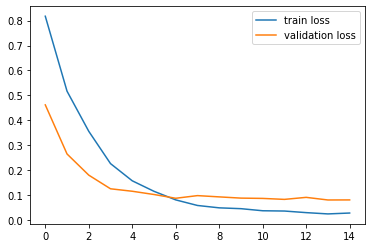

In [ ]:
# Plot for train and validation loss
import matplotlib.pyplot as plt
x = range(15)
plt.plot(x, losses_train[:15], label = "train loss")
plt.plot(x, losses_val[:15], label = "validation loss")
plt.legend()
plt.show()

# Test Result

In [ ]:
loss_test, pr, label, metric = val_test(model, test_dataloader)

<ipython-input-24-96e9b0b47c6b>:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_c = softmax(outputs_c).argmax(dim=1, keepdim=True)


In [ ]:
metric

[0.9754339993449066, 0.9980372013618001, 0.9284770228880388]

In [ ]:
c_eval, m_eval, t_eval = eval_all(pr, label)

In [ ]:
c_eval

[0.9754339993449066,
 0.9754339993449066,
 0.9754339993449066,
 0.9754339993449066,
 0.9736621000012881,
 array([[215,   0,   0,   0,   1,   0,   2,   0,   0,   1,   0,   0,   0,
           0,   0],
        [  0, 122,   0,   1,   0,   2,   0,   0,   0,   0,   0,   1,   1,
           0,   0],
        [  0,   0, 250,   0,   1,   0,   0,   1,   2,   1,   0,   0,   2,
           0,   1],
        [  0,   3,   0, 153,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   1,   0, 169,   2,   1,   0,   2,   0,   0,   0,   1,
           1,   0],
        [  0,   0,   1,   3,   3, 129,   1,   0,   0,   0,   0,   3,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0, 118,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  3,   0,   0,   0,   0,   1,   0, 221,   1,   1,   0,   0,   0,
           1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 235,   0,   0,   0,   1,
           0,   0],
        [  1,   0,   1,   0,   0,   0,   0,   2, 

In [ ]:
m_eval

[0.9980372013618001, 0.9997766727213175, 0.9989061797736646]

In [ ]:
t_eval

[0.9284770228880388, 0.9979312841553654, 0.9619521099153304]

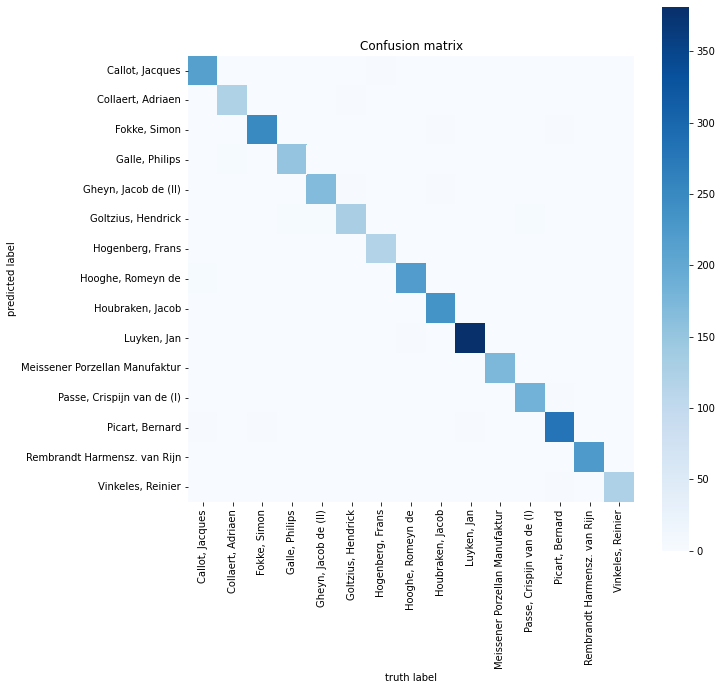

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
sns.heatmap(c_eval[5],square=True,fmt='d',cbar=True,xticklabels=encoder_c.classes_,yticklabels=encoder_c.classes_,cmap=plt.cm.Blues,ax=ax)
#plt.colorbar()
plt.ylabel('predicted label')
plt.xlabel('truth label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
root_path = drive / "model"
path=os.path.join(root_path / 'CL_model_parameter_MTL.txt')
torch.save(model.state_dict(),path)

path2=os.path.join(root_path / 'CL_optimizer_paramenter_MTL.txt')
torch.save(optimizer.state_dict(),path2)

In [ ]:
with open(drive / "model" / "train_loss.pickle", 'wb') as pickle_file:
  pickle.dump(losses_train,pickle_file)
pickle_file.close()

with open(drive / "model" / "val_loss", 'wb') as pickle_file:
  pickle.dump(losses_val, pickle_file)
pickle_file.close()